# Evaluating Price Prediction Performance in Frontier Model

- Build a framework to solve a commercial problem using a Frontier Model
- Run our test dataset against GPT-4o-mini
- Run our test dataset against Claude-3.5-Sonnet

We're not going to give the frontier models any benefit of the training data. We're simply give the test data and ask it to predict the outcome    
Worth noting that the models are not trained for this particular task on the other hand, they may have seen this data from Amazon or HuggingFace dataset.      
(Test Data Contamination)

# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Enter The Frontier!

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic
import google.generativeai as google_genai

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from amazon_items import Item
from testing import Tester

In [6]:
openai = OpenAI()
claude = Anthropic()
google_genai.configure()

In [7]:
%matplotlib inline

In [8]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

# Before we look at the Frontier

## There is one more model we could consider

An human reading through the 250 product descriptions and try to predict the price      
This code reads the prompts and index number from an input file and  outputs a csv file with 250 test prompts

In [9]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [10]:
# Read it back in

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [11]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $374.41 Error: $254.41 SLE: 1.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $80.00 Truth: $225.11 Error: $145.11 SLE: 1.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $35.00 Truth: $61.68 Error: $26.68 SLE: 0.31 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $350.00 Truth: $599.99 Error: $249.99 SLE: 0.29 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $75.00 Truth: $16.99 Error: $58.01 SLE: 2.08 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.00 Truth: $31.99 Error: $19.99 SLE: 0.87 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $115.00 Truth: $101.79 Error: $13.21 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $100.00 Truth: $289.00 Error: $189.00 SLE: 1.11 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $300.00 Truth: $635.86 Error: $335.86 SLE: 0.56 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $80.00 Truth: $65.99 Error: $14.01 SLE: 0.0

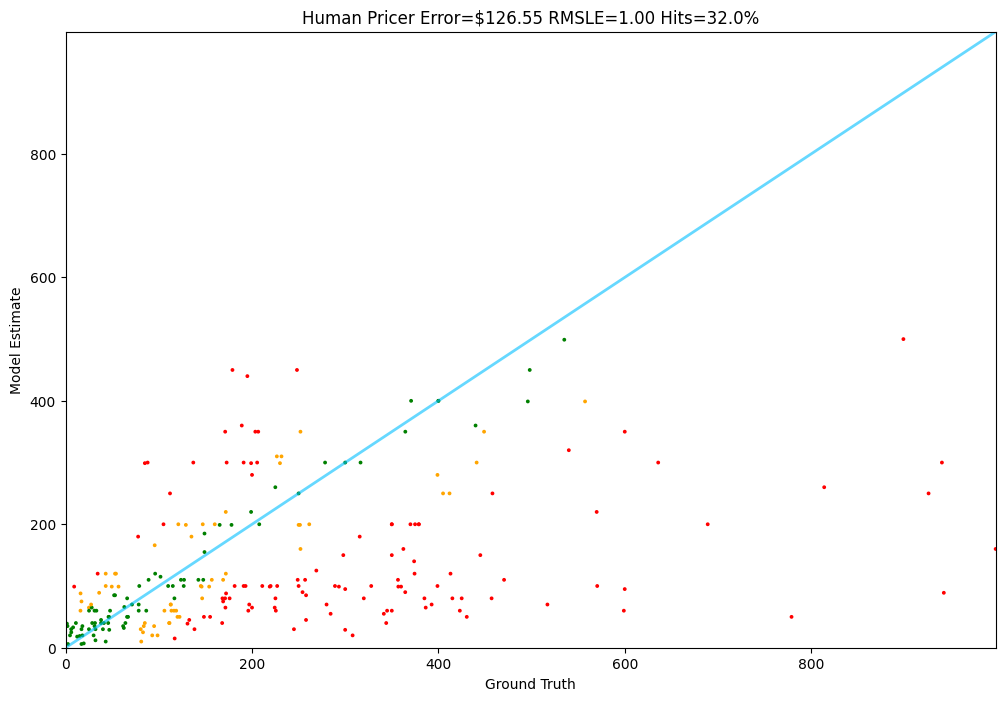

In [12]:
Tester.test(human_pricer, test)

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [13]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [14]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [15]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [16]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [17]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [18]:
gpt_4o_mini(test[0])

180.0

In [19]:
test[0].price

374.41

In [20]:
test[0].details

'{"Manufacturer": "BuyAutoParts", "Brand": "BUYAUTOPARTS!", "Item Weight": "19.3 pounds", "Product Dimensions": "12.1 x 9.6 x 11.5 inches", "Manufacturer Part Number": "60-83447RN", "OEM Part Number": "0210064 0212 11620401, 11620402 11707071 11707072, 11709861 11709862 120415, 12-0415 1534012 15-34012, 1534032 15-34032", "Best Sellers Rank": {"Automotive": 1343916, "Automotive Replacement Air Conditioning Compressors": 5433}, "Date First Available": "June 8, 2015"}'

1: Guess: $180.00 Truth: $374.41 Error: $194.41 SLE: 0.53 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $75.00 Truth: $225.11 Error: $150.11 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $45.99 Truth: $61.68 Error: $15.69 SLE: 0.08 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $379.99 Truth: $599.99 Error: $220.00 SLE: 0.21 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $29.99 Truth: $16.99 Error: $13.00 SLE: 0.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $49.99 Truth: $101.79 Error: $51.80 SLE: 0.49 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $599.00 Truth: $289.00 Error: $310.00 SLE: 0.53 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $499.99 Truth: $635.86 Error: $135.87 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $47.99 Truth: $65.99 Error: $18.00 SLE: 0.10

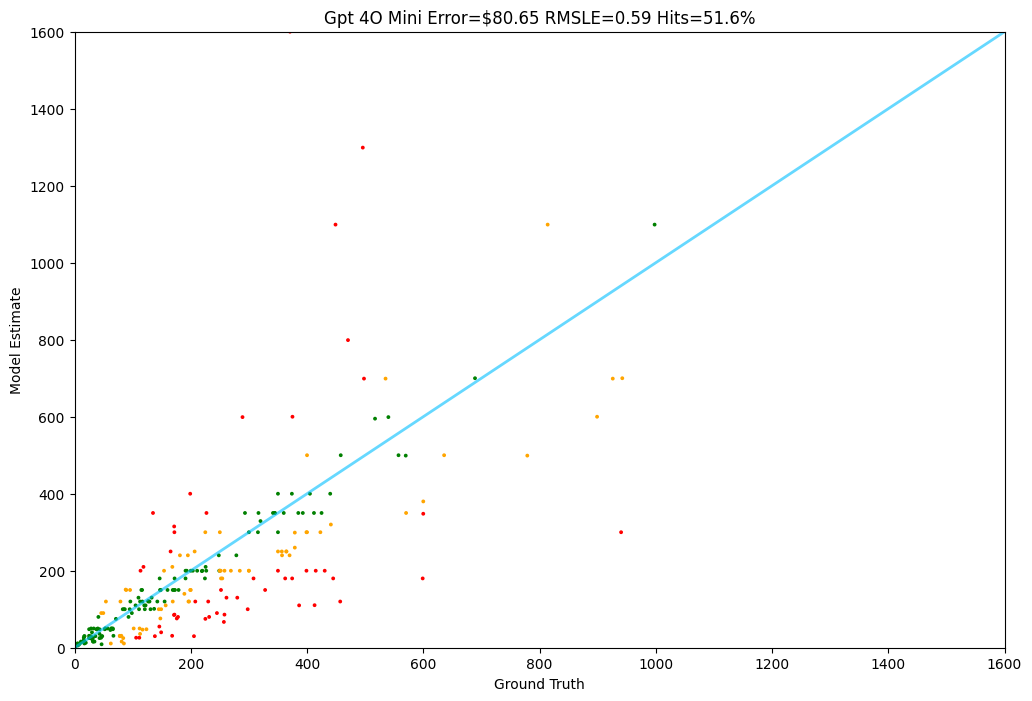

In [21]:
Tester.test(gpt_4o_mini, test)

## Claude

In [22]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

1: Guess: $349.99 Truth: $374.41 Error: $24.42 SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $179.99 Truth: $225.11 Error: $45.12 SLE: 0.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $39.99 Truth: $61.68 Error: $21.69 SLE: 0.18 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $389.99 Truth: $599.99 Error: $210.00 SLE: 0.18 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $19.99 Truth: $16.99 Error: $3.00 SLE: 0.02 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $17.99 Truth: $31.99 Error: $14.00 SLE: 0.31 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $99.99 Truth: $101.79 Error: $1.80 SLE: 0.00 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $329.00 Truth: $289.00 Error: $40.00 SLE: 0.02 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $399.99 Truth: $635.86 Error: $235.87 SLE: 0.21 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $59.99 Truth: $65.99 Error: $6.00 SLE: 0.01 Item

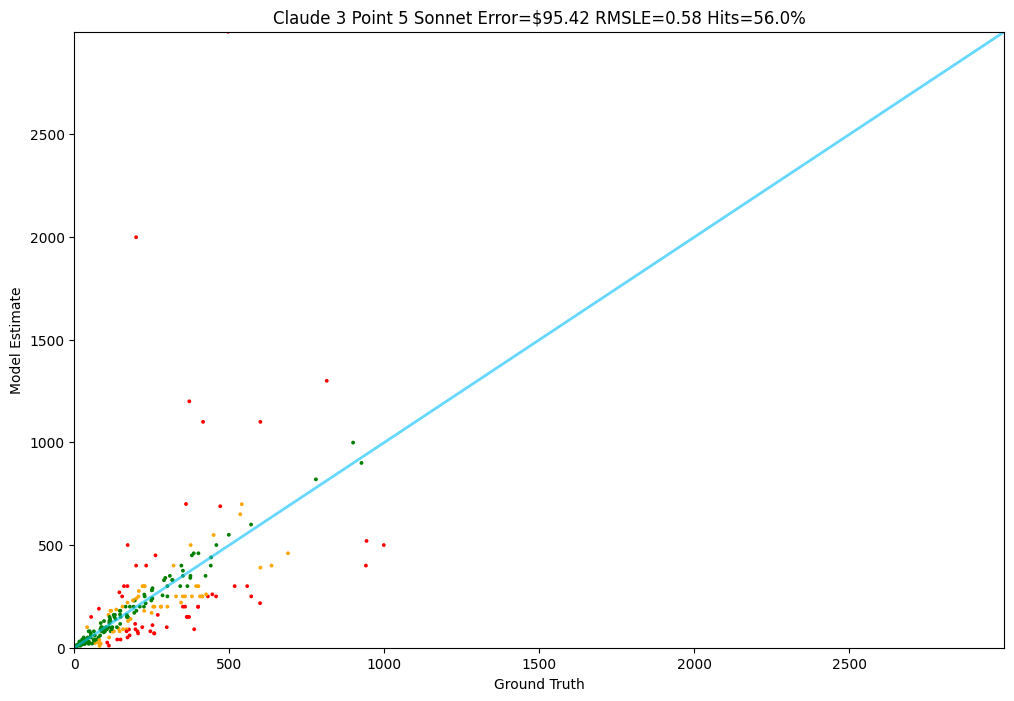

In [23]:
# The function for Claude 3.5 Sonnet
# It also cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(claude_3_point_5_sonnet, test)

## Gemini

In [24]:
# Function to create the messages format required for Gemini 1.5 Pro
# This function prepares the system and user messages in the format expected by Gemini models.
def gemini_messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    
    # Modify the test prompt by removing "to the nearest dollar" and "Price is $"
    # This ensures that the model receives a cleaner, simpler prompt.
    user_prompt = item.test_prompt().replace(" to the nearest dollar", "").replace("\n\nPrice is $", "")

    # Reformat messages to Gemini’s expected format: messages = [{'role':'user', 'parts': ['hello']}]
    return [
        {"role": "system", "parts": [system_message]},  # System-level instruction
        {"role": "user", "parts": [user_prompt]},       # User's query
        {"role": "model", "parts": ["Price is $"]}  # Assistant's expected prefix for response
    ]

In [25]:
# Function to get the estimated price using Gemini 1.5 Pro
def gemini_2_point_5_pro(item):
    messages = gemini_messages_for(item)  # Generate messages for the model
    system_message = messages[0]['parts'][0]  # Extract system-level instruction
    user_messages = messages[1:]  # Remove system message from messages list
    
    # Initialize Gemini 1.5 Pro model with system instruction
    gemini = google_genai.GenerativeModel(
        model_name="gemini-2.5-pro-exp-03-25", #"gemini-1.5-pro", #"gemini-2.5-pro-exp-03-25",  #
        system_instruction=system_message
    )

    # Generate response using Gemini API
    response = gemini.generate_content(
        contents=user_messages,
        generation_config=google_genai.GenerationConfig(max_output_tokens=5)
    )

    # Extract text response and convert to numerical price
    return get_price(response.text)

In [26]:
gemini_2_point_5_pro(test[0])

200.0

In [27]:
# Retrieve the actual price of the test item (for comparison)
test[0].price  

374.41

In [28]:
Tester.test(gemini_2_point_5_pro, test)

1: Guess: $236.50 Truth: $374.41 Error: $137.91 SLE: 0.21 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $150.00 Truth: $225.11 Error: $75.11 SLE: 0.16 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $67.99 Truth: $61.68 Error: $6.31 SLE: 0.01 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $550.00 Truth: $599.99 Error: $49.99 SLE: 0.01 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $13.59 Truth: $16.99 Error: $3.40 SLE: 0.04 Item: 5-Position Super Switch Pickup Selector ...


ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 9
}
]

### Ollama

In [29]:
import ollama

In [30]:
# The function for gpt-4o-mini

def ollama_gemma(item):
    response = ollama.chat(
        model="gemma3", 
        messages=messages_for(item),
    )
    reply = response['message']['content']
    return get_price(reply)

In [31]:
ollama_gemma(test[0])

189.99

1: Guess: $189.99 Truth: $374.41 Error: $184.42 SLE: 0.46 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $80.00 Truth: $225.11 Error: $145.11 SLE: 1.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $25.99 Truth: $61.68 Error: $35.69 SLE: 0.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $179.00 Truth: $599.99 Error: $420.99 SLE: 1.45 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $35.99 Truth: $16.99 Error: $19.00 SLE: 0.52 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.99 Truth: $31.99 Error: $19.00 SLE: 0.74 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $35.99 Truth: $101.79 Error: $65.80 SLE: 1.04 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $239.99 Truth: $289.00 Error: $49.01 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $1,499.99 Truth: $635.86 Error: $864.13 SLE: 0.74 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $35.99 Truth: $65.99 Error: $30.00 SLE: 0.3

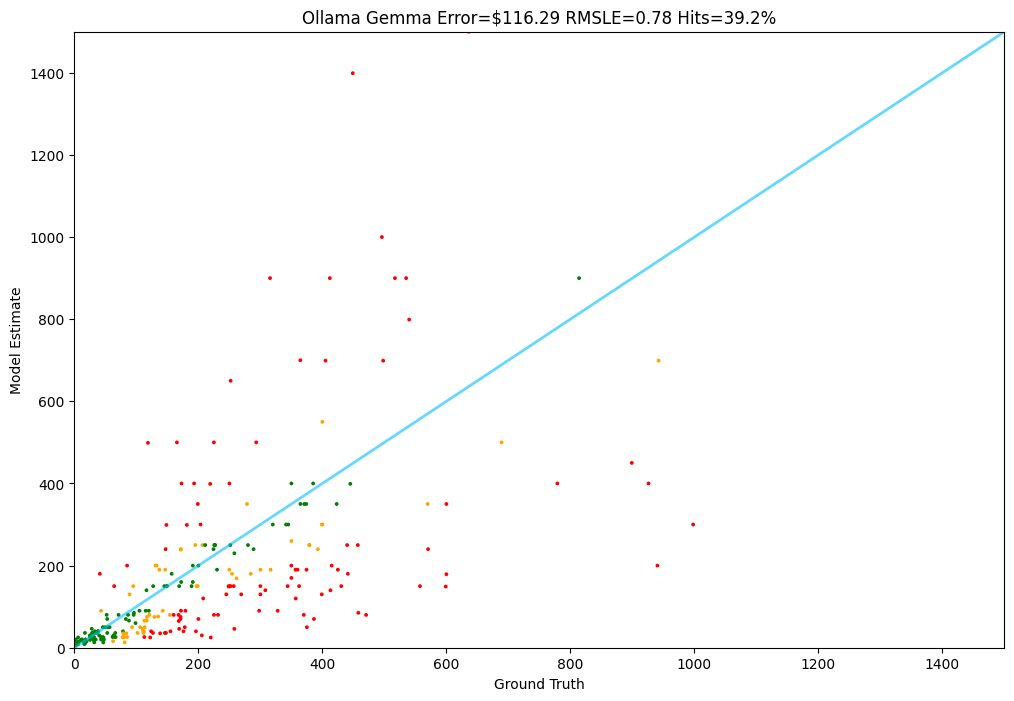

In [32]:
Tester.test(ollama_gemma, test)

In [33]:
# The function for gpt-4o-mini

def ollama_gemma_12b(item):
    response = ollama.chat(
        model="gemma3:12b", 
        messages=messages_for(item),
    )
    reply = response['message']['content']
    return get_price(reply)

1: Guess: $289.99 Truth: $374.41 Error: $84.42 SLE: 0.06 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $45.99 Truth: $225.11 Error: $179.12 SLE: 2.47 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $35.00 Truth: $61.68 Error: $26.68 SLE: 0.31 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $279.99 Truth: $599.99 Error: $320.00 SLE: 0.58 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $25.00 Truth: $16.99 Error: $8.01 SLE: 0.14 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.00 Truth: $31.99 Error: $16.99 SLE: 0.52 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $79.99 Truth: $101.79 Error: $21.80 SLE: 0.06 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $229.99 Truth: $289.00 Error: $59.01 SLE: 0.05 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $499.00 Truth: $635.86 Error: $136.86 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $35.00 Truth: $65.99 Error: $30.99 SLE: 0.39 It

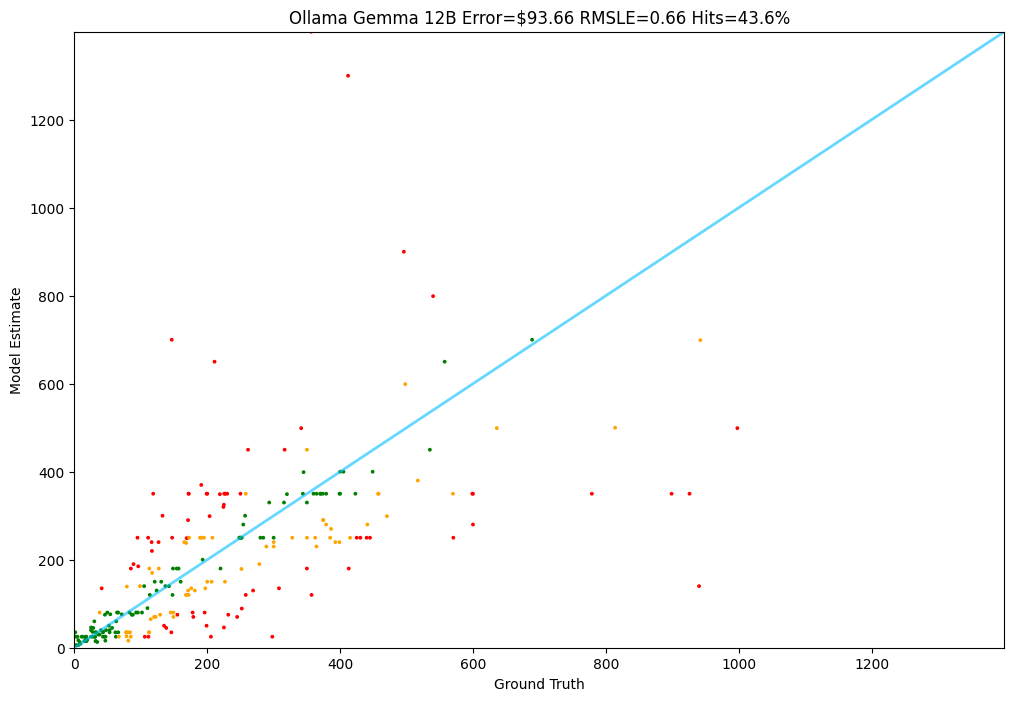

In [34]:
Tester.test(ollama_gemma_12b, test)

In [35]:
# The function for gpt-4o-mini

def ollama_gemma_27b(item):
    response = ollama.chat(
        model="gemma3:27b", 
        messages=messages_for(item),
    )
    reply = response['message']['content']
    return get_price(reply)

1: Guess: $229.95 Truth: $374.41 Error: $144.46 SLE: 0.24 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $40.00 Truth: $225.11 Error: $185.11 SLE: 2.92 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $27.99 Truth: $61.68 Error: $33.69 SLE: 0.59 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $435.00 Truth: $599.99 Error: $164.99 SLE: 0.10 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $13.99 Truth: $16.99 Error: $3.00 SLE: 0.03 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.99 Truth: $31.99 Error: $19.00 SLE: 0.74 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $79.99 Truth: $101.79 Error: $21.80 SLE: 0.06 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $279.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $399.00 Truth: $635.86 Error: $236.86 SLE: 0.22 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $39.99 Truth: $65.99 Error: $26.00 SLE: 0.24 I

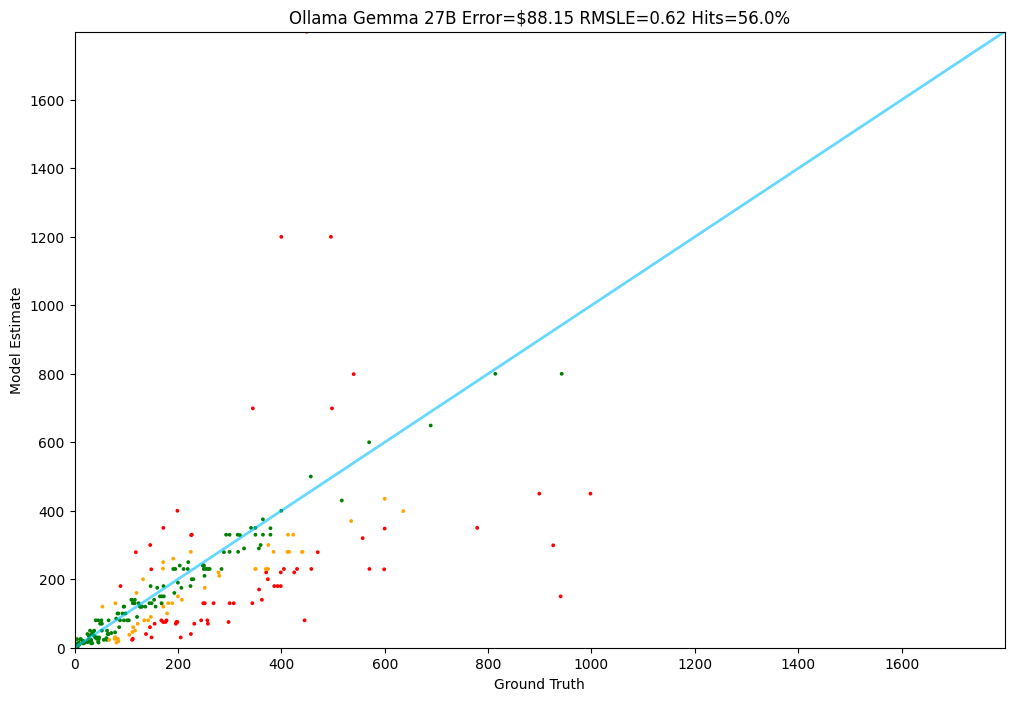

In [36]:
Tester.test(ollama_gemma_27b, test)